# ROMY & FUR - Overview

## Load Libraries

In [1]:
import os, sys
import pickle
import matplotlib.pyplot as plt
import numpy as np

from obspy import UTCDateTime, read_inventory
from scipy.signal import welch
from pandas import read_pickle, DataFrame

from functions.get_time_intervals import __get_time_intervals


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
from functions.get_time_intervals import __get_time_intervals

In [4]:
config = {}

config['tbeg'] = UTCDateTime("2023-09-20")
config['tend'] = UTCDateTime("2023-09-30")

# config['tbeg'] = UTCDateTime("2023-12-01")
# config['tend'] = UTCDateTime("2023-12-31")

config['path'] = data_path+"VelocityChanges/data/all/"
# config['path_all'] = data_path+"VelocityChanges/data/all/"

config['path_to_figs'] = data_path+"VelocityChanges/figures/"


### Load Data

In [5]:
dates = __get_time_intervals(config['tbeg'], config['tend'], interval_seconds=86400, interval_overlap=0)


baz_love, baz_rayleigh, baz_tangent = np.array([]), np.array([]), np.array([])
vel_love, vel_rayleigh, vel_bf = np.array([]), np.array([]), np.array([])
std_love, std_rayleigh, std_bf = np.array([]), np.array([]), np.array([])
cc_love, cc_rayleigh, cc_bf, cc_tangent = np.array([]), np.array([]), np.array([]), np.array([])
ttt = np.array([])

for _n, (d1, d2) in enumerate(dates):

    filename = f"VC_BAZ_{d1.date}_all.pkl"

    if os.path.isfile(config['path']+filename):
        print(f"loading: {filename}")
        out = read_pickle(config['path']+filename)
    else:
        print(f"-> no file for {filename}")

    # print(out.keys())

    try:
        vel_love = np.append(vel_love, out['vel_love_all'])
        vel_rayleigh = np.append(vel_rayleigh, out['vel_rayleigh_all'])
        vel_bf = np.append(vel_bf, out['vel_bf_all'])

        baz_love = np.append(baz_love, out['baz_love_all'])
        baz_rayleigh = np.append(baz_rayleigh, out['baz_rayleigh_all'])
        baz_tangent = np.append(baz_tangent, out['baz_tangent_all'])

        cc_love = np.append(cc_love, out['cc_love_all'])
        cc_rayleigh = np.append(cc_rayleigh, out['cc_rayleigh_all'])
        cc_tangent = np.append(cc_tangent, out['cc_tangent_all'])


        ttt = np.append(ttt, out['time'])

    except:
        print(f" -> skipping: {filename}")
        continue

## remove nan values based on time array
bad = []
for _i, tt in enumerate(ttt):
    if str(type(tt)) != "<class 'obspy.core.utcdatetime.UTCDateTime'>":
        bad.append(_i)



loading: VC_BAZ_2023-09-20_all.pkl
loading: VC_BAZ_2023-09-21_all.pkl
loading: VC_BAZ_2023-09-22_all.pkl
loading: VC_BAZ_2023-09-23_all.pkl
loading: VC_BAZ_2023-09-24_all.pkl
loading: VC_BAZ_2023-09-25_all.pkl
-> no file for VC_BAZ_2023-09-26_all.pkl
-> no file for VC_BAZ_2023-09-27_all.pkl
-> no file for VC_BAZ_2023-09-28_all.pkl
-> no file for VC_BAZ_2023-09-29_all.pkl


### Make DataFrames

In [6]:
## _____________________________
df_rayleigh = DataFrame()

df_rayleigh['time'] = ttt
df_rayleigh['cc'] = cc_rayleigh
df_rayleigh['vel'] = vel_rayleigh
df_rayleigh['baz'] = baz_rayleigh


df_rayleigh = df_rayleigh.dropna(subset=['time']).reset_index()

df_rayleigh['time_relative'] = df_rayleigh.time - df_rayleigh.time.iloc[0]

## _____________________________
df_love = DataFrame()

df_love['time'] = ttt
df_love['cc'] = cc_love
df_love['vel'] = vel_love
df_love['baz'] = baz_love

df_love = df_love.dropna(subset=['time']).reset_index()

df_love['time_relative'] = df_love.time - df_love.time.iloc[0]

## _____________________________
df_tangent = DataFrame()

df_tangent['time'] = ttt
df_tangent['cc'] = cc_tangent
df_tangent['baz'] = baz_tangent

df_tangent = df_tangent.dropna(subset=['time']).reset_index()

df_tangent['time_relative'] = df_tangent.time - df_tangent.time.iloc[0]


## Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


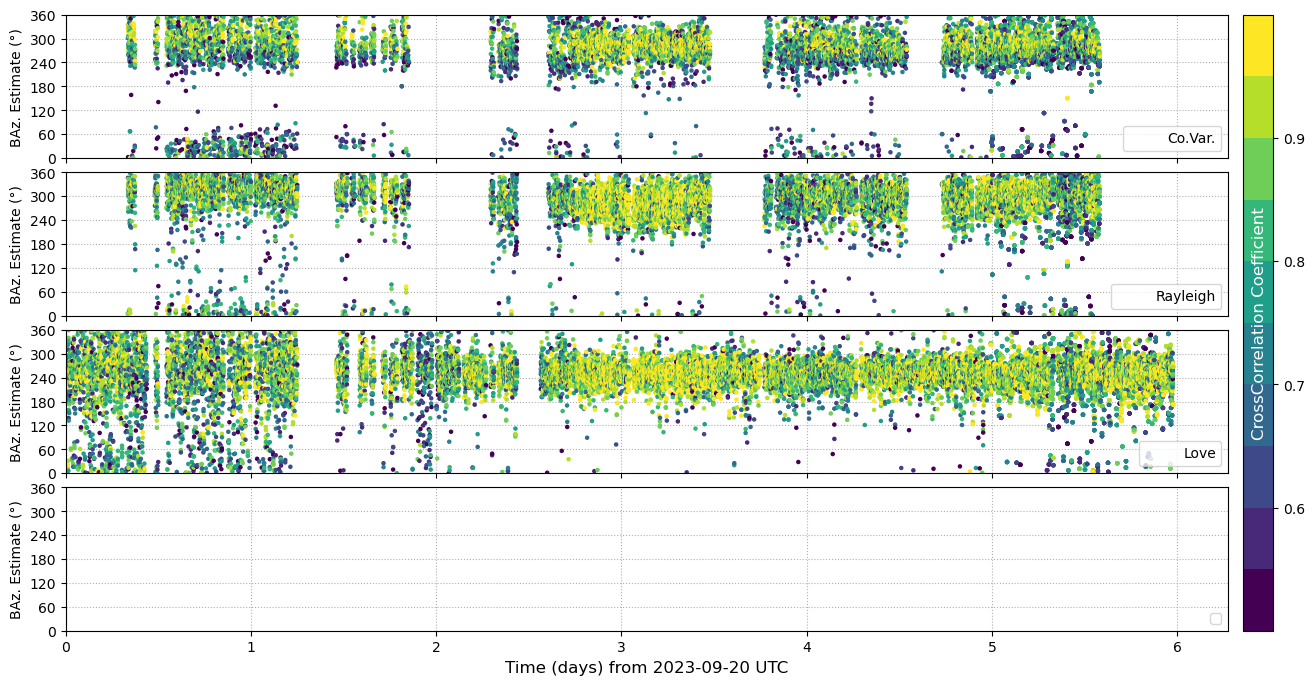

In [12]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    cmap = plt.get_cmap("viridis", 10)

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    time_scaling = 1/86400

    im0 = ax[0].scatter(df_tangent.time_relative*time_scaling, df_tangent.baz,
                        c=df_tangent.cc, s=5, label="Co.Var.", zorder=2, cmap=cmap)
    im1 = ax[1].scatter(df_rayleigh.time_relative*time_scaling, df_rayleigh.baz,
                        c=df_rayleigh.cc, s=5, label="Rayleigh", zorder=2, cmap=cmap)
    im2 = ax[2].scatter(df_love.time_relative*time_scaling, df_love.baz,
                        c=df_love.cc, s=5, label="Love", zorder=2, cmap=cmap)
    # ax[3].scatter(df_bf.time_relative*time_scaling, df_bf.baz,
    #               color="tab:orange", label="Beamforming", zorder=2, cmap=cmap)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=4)
        ax[_n].set_ylim(0, 360)
        ax[_n].set_yticks(np.arange(0, 360+60, 60))
        ax[_n].set_ylabel("BAz. Estimate (°)")
        ax[_n].set_xlim(left=0)

    ax[Nrow-1].set_xlabel(f"Time (days) from {config['tbeg'].date} UTC", fontsize=font)

    ## add colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.02, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im1, cax=cbar_ax)
    cb.set_label("CrossCorrelation Coefficient", fontsize=font, labelpad=-38, color="white")

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"BAZ_timeline_{config['tbeg'].date}_{config['tend'].date}.png", format="png", dpi=150, bbox_inches='tight')


In [8]:
def circular_hist(ax, x, nbins=72, density=True, offset=0, gaps=True, weights=None):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        nbins = np.linspace(-np.pi, np.pi, num=nbins+1)

    # Bin data and record counts
    if weights is not None:
        n, bins = np.histogram(x, bins=nbins, range=(-np.pi, np.pi), weights=weights)
    else:
        n, bins = np.histogram(x, bins=nbins, range=(-np.pi, np.pi))

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=2, align='edge', width=widths,
                     edgecolor='darkred', fill=False, linewidth=0.7)

    # Set the direction of the zero angle
    # ax.set_theta_offset(offset)
    ax.set_theta_zero_location("N")  # theta=0 at the top

    ax.set_theta_direction(-1)  # theta increasing clockwise

    ax.grid(zorder=0)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

NameError: name 'baz1' is not defined

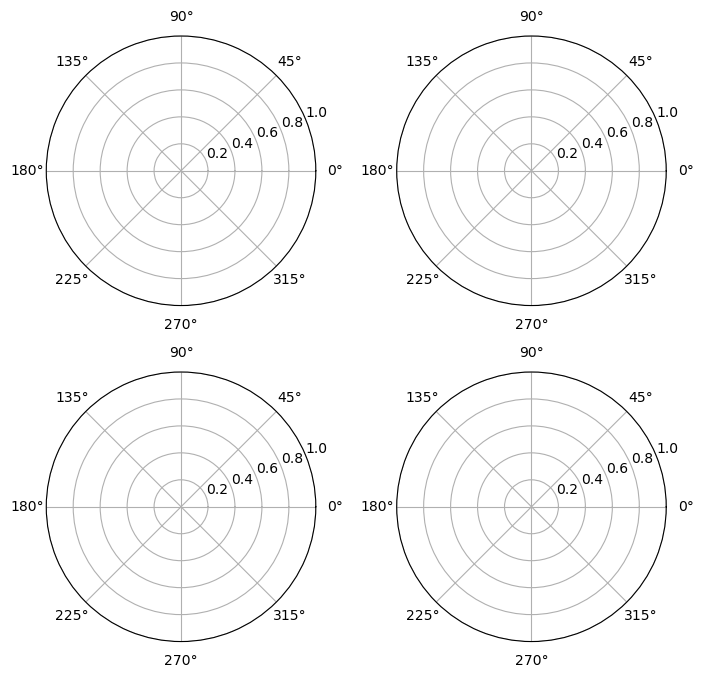

In [9]:
def __makeplot_polar(weight=False):

    import matplotlib.pyplot as plt
    import numpy as np

    font = 12

    # weight = False

    # Construct figure and axis to plot on
    fig, ax = plt.subplots(2, 2, subplot_kw=dict(projection='polar'), figsize=(8, 8))

    plt.subplots_adjust(wspace=0.3)

    if weight:
        circular_hist(ax[0,0], np.deg2rad(baz1), weights=1/np.deg2rad(std1), density=True)
        circular_hist(ax[0,1], np.deg2rad(baz2), weights=1/np.deg2rad(std2), density=True)
        circular_hist(ax[1,0], np.deg2rad(baz3), weights=1/np.deg2rad(std3), density=True)
        circular_hist(ax[1,1], np.deg2rad(baz4), weights=1/np.deg2rad(std4), density=True)
    else:
        circular_hist(ax[0,0], np.deg2rad(baz1), density=False)
        circular_hist(ax[0,1], np.deg2rad(baz2), density=False)
        circular_hist(ax[1,0], np.deg2rad(baz3), density=False)
        circular_hist(ax[1,1], np.deg2rad(baz4), density=False)

    ax[0,0].set_title("(a) Co.Var.", loc="left")
    ax[0,1].set_title("(b) Beamforming", loc="left")
    ax[1,0].set_title("(c) Love", loc="left")
    ax[1,1].set_title("(d) Rayleigh", loc="left")

    for i in range(2):
        for j in range(2):
            ax[i,j].grid(color="k", zorder=0, ls="--", alpha=0.5)

    plt.suptitle(f"Backazimuth Estimation:  BW.ROMY - GR.FUR  ({config['tbeg'].date} - {config['tend'].date})", fontsize=font+1)

    plt.show();
    return fig

fig = __makeplot_polar()

fig.savefig(config['path_to_figs']+f"BAZ_polar_{config['tbeg'].date}_{config['tend'].date}.png", format="png", dpi=150, bbox_inches='tight')


### Plot on Map

NameError: name 'baz1' is not defined

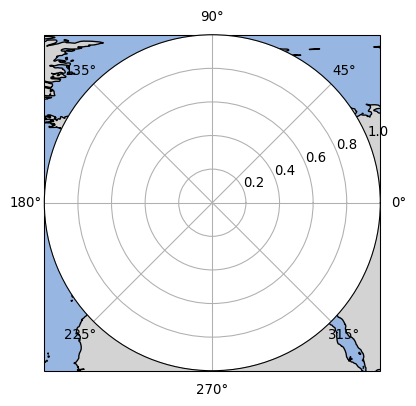

In [13]:
def __makeplot_maps(weights=False, density=False):

    import gc
    import matplotlib.colors
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import matplotlib.pyplot as mpl
    import cartopy.feature as cfeature

    romy_lon = 11.275501
    romy_lat = 48.162941

    flatMap = ccrs.PlateCarree()

    resolution = '50m'

    # weights = False
    # density = False

    font = 12

    fig = plt.figure(figsize=(10, 10), dpi=96)

    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    ## ________________________________________________
    ## CoVar

    ax0 = fig.add_subplot(221, projection=flatMap)

    ax0.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=[romy_lon-35, romy_lon+35, romy_lat-35, romy_lat+35]
             )

    ax0.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor="lightgrey"))

    ax00 = fig.add_subplot(221, projection='polar')

    if weights:
        circular_hist(ax00, np.deg2rad(baz1), weights=1/np.deg2rad(std1), density=density)
    else:
        circular_hist(ax00, np.deg2rad(baz1), density=density)

    ax00.patch.set_alpha(0.)
    ax00.grid(color="k", ls="--", alpha=0.5)

    ax00.grid(color="k", zorder=0)


    ## ________________________________________________
    ## Beamforming

    ax1 = fig.add_subplot(222, projection=flatMap)

    ax1.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=[romy_lon-35, romy_lon+35, romy_lat-35, romy_lat+35]
             )

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor="lightgrey"))


    ax01 = fig.add_subplot(222, projection='polar')

    if weights:
        circular_hist(ax01, np.deg2rad(baz2), weights=1/np.deg2rad(std2), density=density)
    else:
        circular_hist(ax01, np.deg2rad(baz2), density=density)

    ax01.patch.set_alpha(0.)
    ax01.grid(color="k", ls="--", alpha=0.5)

    ax01.grid(color="k", zorder=0)


    ## ________________________________________________
    ## Love

    ax2 = fig.add_subplot(223, projection=flatMap)

    ax2.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=[romy_lon-35, romy_lon+35, romy_lat-35, romy_lat+35]
             )

    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor="lightgrey"))

    ax02 = fig.add_subplot(223, projection='polar')

    if weights:
        circular_hist(ax02, np.deg2rad(baz3), weights=1/np.deg2rad(std3), density=density)
    else:
        circular_hist(ax02, np.deg2rad(baz3), density=density)

    ax02.patch.set_alpha(0.)
    ax02.grid(color="k", ls="--", alpha=0.5)

    ax02.grid(color="k", zorder=0)


    ## ________________________________________________
    ## Rayleigh

    ax3 = fig.add_subplot(224, projection=flatMap)


    ax3.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=[romy_lon-35, romy_lon+35, romy_lat-35, romy_lat+35]
             )

    # ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor=cfeature.COLORS['land']))
    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor="lightgrey"))

    ax03 = fig.add_subplot(224, projection='polar')

    if weights:
        circular_hist(ax03, np.deg2rad(baz4), weights=1/np.deg2rad(std4), density=density)
    else:
        circular_hist(ax03, np.deg2rad(baz4), density=density)



    ax03.patch.set_alpha(0.)
    ax03.grid(color="k", ls="--", alpha=0.5)

    ax03.grid(color="k", zorder=0)


    ax0.set_title("(a) Co-Variance", pad=15, loc="left", fontsize=font)
    ax1.set_title("(b) Beamforming", pad=15, loc="left", fontsize=font)
    ax2.set_title("(c) Love waves", pad=15, loc="left", fontsize=font)
    ax3.set_title("(d) Rayleigh waves", pad=15, loc="left", fontsize=font)

    plt.suptitle(f"Backazimuth Estimation:  BW.ROMY - GR.FUR  ({config['tbeg'].date} - {config['tend'].date})", fontsize=font+1, y=0.95)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot_maps()

fig.savefig(config['path_to_figs']+f"BAZ_maps_{config['tbeg'].date}_{config['tend'].date}.png", format="png", dpi=150, bbox_inches='tight')


## Velocities

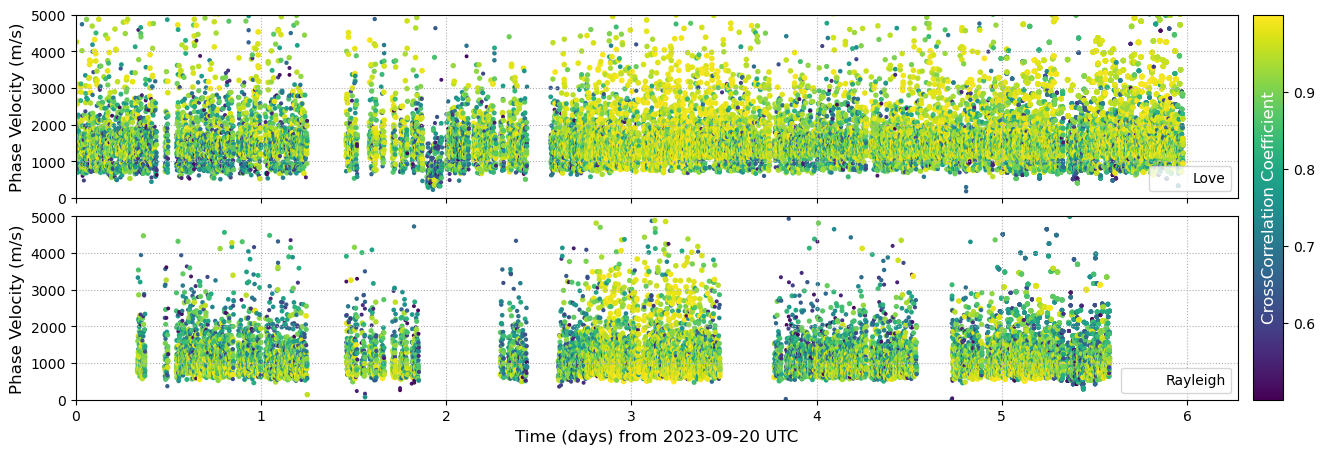

In [16]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    cmap = plt.get_cmap("viridis", 10)

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    time_scaling = 1/86400

    im0 = ax[0].scatter(df_love.time_relative*time_scaling, df_love.vel,
                        s=10**df_love.cc, c=df_love.cc, label="Love")

    ax[1].scatter(df_rayleigh.time_relative*time_scaling, df_rayleigh.vel,
                  s=10**df_rayleigh.cc, c=df_rayleigh.cc, label="Rayleigh")


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0, which="both")
        ax[_n].legend(loc=4, fontsize=font-2)
        ax[_n].set_ylim(0, 5000)
        # ax[_n].set_yticks(np.arange(0, 360+60, 60))
        ax[_n].set_ylabel("Phase Velocity (m/s)", fontsize=font)
        ax[_n].set_xlim(left=0)
        # ax[_n].set_yscale("log")

    ax[Nrow-1].set_xlabel(f"Time (days) from {config['tbeg'].date} UTC", fontsize=font)

    ## add colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.02, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im0, cax=cbar_ax)
    cb.set_label("CrossCorrelation Coefficient", fontsize=font, labelpad=-38, color="white")

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"BAZ_timeline_{config['tbeg'].date}_{config['tend'].date}.png", format="png", dpi=150, bbox_inches='tight')
